### Make required imports

In [1]:
#install interpret
!pip install interpret
!pip install kaleido



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import ability to modify google drive
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
from google.colab import files

# define working directory for current drive -- hopefully this populates the
# projects drive and not the user's
working_directory = '/content/drive/My Drive/COS Seesaw Research'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import shutil
from sklearn.model_selection import train_test_split
from interpret import show
from interpret import data
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from interpret.perf import RegressionPerf

warnings.filterwarnings("ignore")
cos_site = 'mlo'
cos_target = 'COS_' + cos_site

### Build out file hierarchy

In [4]:
results_path = working_directory +'/Results'
if not os.path.isdir(results_path):
    os.mkdir(results_path)

site_path = working_directory + '/Results/' + cos_site + '_Results'
if not os.path.isdir(site_path):
    # directory for this target site does not exist, so we need to make it
    os.mkdir(site_path)
performance_path = site_path + '/Performance'

if not os.path.isdir(performance_path):
    # make directory if it does not already exist
    os.mkdir(performance_path)
else:
    # delete contents of directory and start anew if it exists
    shutil.rmtree(performance_path)
    os.mkdir(performance_path)
    
yearly_path = performance_path + '/Yearly'
if not os.path.isdir(yearly_path):
    os.mkdir(yearly_path)
    
    
shape_path = working_directory + '/Results/' + cos_site + '_Results/Shape_Functions'

if not os.path.isdir(shape_path):
    os.mkdir(shape_path)
else:
    # delete contents of directory and start anew if it exists
    shutil.rmtree(shape_path)
    os.mkdir(shape_path)


### Load dataframe and separate feature and target sets

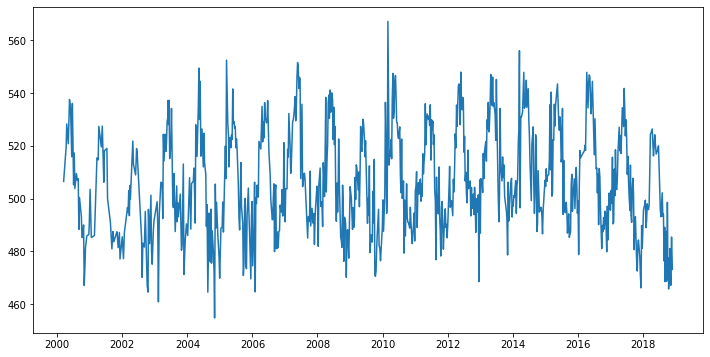

In [5]:
from datetime import datetime as dt
df = pd.read_pickle(working_directory + '/Data/Pickles/COS_Seesaw_dataframe_' + cos_site + '.pkl')

columns = list(df.columns)
if cos_target in columns:
    columns.remove(cos_target)
else:
    print('Error, target column not in dataframe')
    quit()
    
x = df[columns]
y = df[cos_target]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df['time'], df[cos_target])
#ax.errorbar(df['time'], df[cos_target], fmt='-v', label='Actual with errorbars (stddev)', yerr=df['OCS_stddev'])
plt.show()

### Make test train split, random seed is to ensure consistent results on multiple runs
### change  seed value to get different split

In [6]:
seed = 5
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

# set up for predicted vs actual plot
# sorting the test set should not matter since we are not using it to train
X_test = X_test.sort_index()
y_test = y_test.sort_index()

test_time = X_test['time']
# divide test set by year and save for later
start = X_test['time'].min().year
end = X_test['time'].max().year
test_by_year = []

for year in range(start, (end + 1)):
    year_X = X_test[X_test['time'].dt.year == year]
    year_y = y_test.where(y_test.index.isin(year_X.index))
    
    year_y.dropna(inplace=True)
    year_time = year_X['time']
    year_stddev = year_X['OCS_stddev']
    year_X.drop(axis=1, labels='time', inplace=True)
    year_X.drop(axis=1, labels='OCS_stddev', inplace=True)
    year_data = (year, year_time, year_X, year_y, year_stddev)
    # year_data = (year, year_time, year_X, year_y)
    test_by_year.append(year_data)

# print(test_by_year)

ocs_stddev_train = X_train['OCS_stddev']
ocs_stddev_test = X_test['OCS_stddev']

X_test.drop(axis=1, labels='time', inplace=True)
X_test.drop(axis=1, labels='OCS_stddev', inplace=True)

#drop time in X_train
X_train.drop(axis=1, labels='time', inplace=True)
X_train.drop(axis=1,labels='OCS_stddev', inplace=True)

### Show Marginal

In [7]:
marginal = data.Marginal()
marginal_explanation = marginal.explain_data(X_train, y_train)
show(marginal_explanation)

Output hidden; open in https://colab.research.google.com to view.

### Train Models

In [8]:
ebm = ExplainableBoostingRegressor(random_state=seed, interactions=3)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['alt_sst', 'alt_sst-15d',
                                            'alt_sst-1m', 'alt_sst-1m15d',
                                            'alt_sst-2m', 'brw_sst',
                                            'brw_sst-15d', 'brw_sst-1m',
                                            'brw_sst-1m15d', 'brw_sst-2m',
                                            'cgo_sst', 'cgo_sst-15d',
                                            'cgo_sst-1m', 'cgo_sst-1m15d',
                                            'cgo_sst-2m', 'hfm_sst',
                                            'hfm_sst-15d', 'hfm_sst-1m',
                                            'hfm_sst-1m15d', 'hfm_sst-2m',
                                            'kum_sst', 'kum_sst-15d',
                                            'kum_sst-1m', 'kum_...
                                            'continuous', 'continuous',
                                            'continuous', 'continuo

### What model learned

In [9]:
ebm_global = ebm.explain_global(name='EBM')

### Explanation of individul prediction

In [10]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')

### Evaluate performance

In [11]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_test, y_test, name='EBM')

### Everything at once

In [12]:
show([marginal_explanation, ebm_global, ebm_perf, ebm_local])

### Save all the shape graphs

In [13]:
# need to figure out how to save importance plot
for index, value in enumerate(ebm.feature_groups_):
    feature_name = ebm_global.feature_names[index]
    path = shape_path + "/" + feature_name + ".png"
    plotly_fig = ebm_global.visualize(index)
    plotly_fig.write_image(path)

RMSE:  11.463239063289334


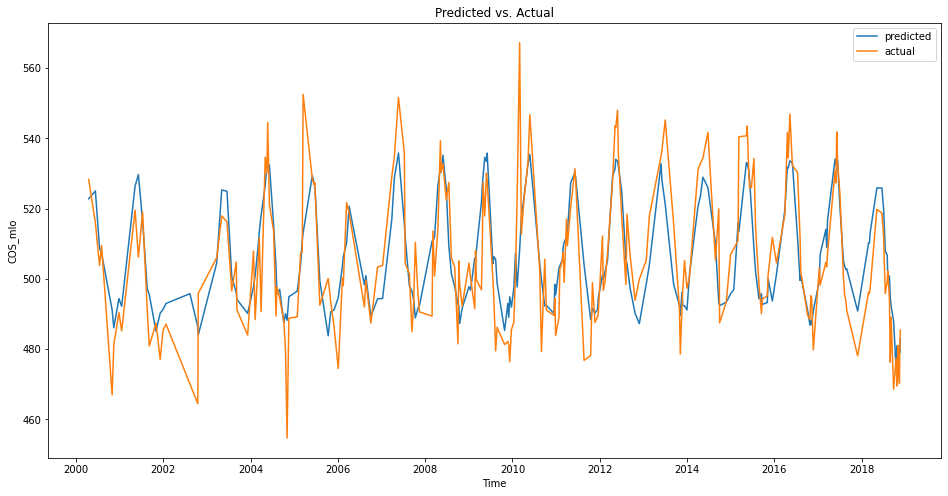

In [14]:
import math
predicted = ebm.predict(X_test)
# rmse
mse = np.square(np.subtract(predicted, y_test)).mean()
rmse = math.sqrt(mse)
print("RMSE: ", rmse)

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_time, predicted, '-',  label='predicted')
ax.plot(test_time, y_test, '-', label='actual')
ax.set_title("Predicted vs. Actual")
ax.set_xlabel('Time')
ax.set_ylabel(cos_target)
plt.legend()
plt.show()
fig.savefig(performance_path + '/predictedVsActual.png')

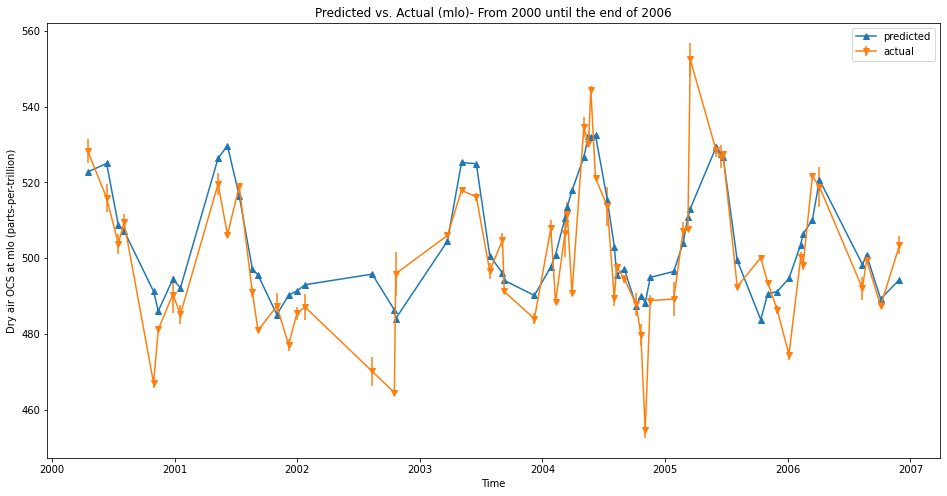

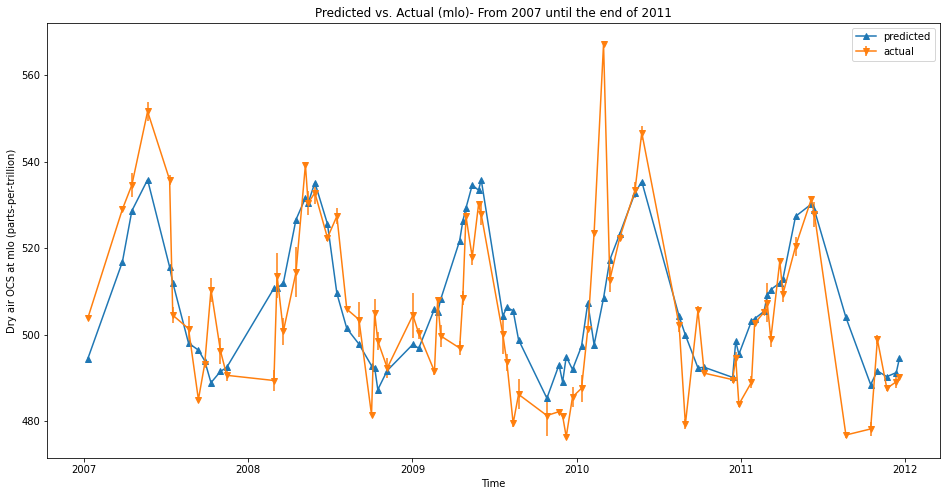

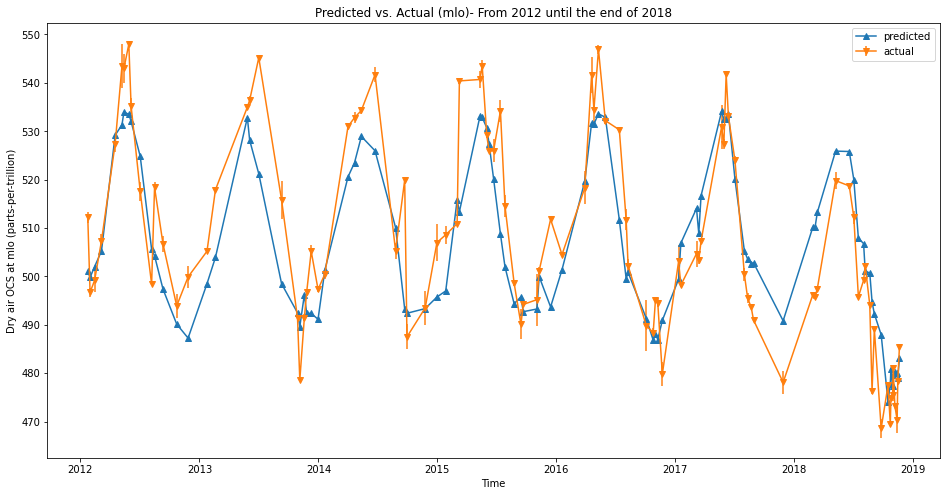

In [15]:
# generate 6 year interval plots
'''
print('TIME:')
print(test_time)
print('PREDICTED')
print(predicted)
print('TEST')
print(y_test)
print('OCS_STDDEV')
print(ocs_stddev_test)
'''
plot_intervals = []

interval_df = pd.DataFrame(data={'time':test_time.tolist(), 'predicted':predicted, 'actual':y_test.tolist(), 'std_dev':ocs_stddev_test.tolist()})
year2001to2006 = interval_df.loc[interval_df['time'].dt.year <= 2006]
plot_intervals.append(year2001to2006)
year2007to2012 = interval_df.loc[((interval_df['time'].dt.year > 2006) & (interval_df['time'].dt.year <= 2011))]
plot_intervals.append(year2007to2012)
year2013to2018 = interval_df.loc[((interval_df['time'].dt.year > 2011) & (interval_df['time'].dt.year <= 2018))]
plot_intervals.append(year2013to2018)

for interval in plot_intervals:
    year_min = interval['time'].min().year
    year_max = interval['time'].max().year
    fig, ax = plt.subplots(figsize=(16,8))
    
    ax.plot(interval['time'], interval['predicted'], '-^', label='predicted')
    ax.errorbar(interval['time'], interval['actual'], yerr=interval['std_dev'], fmt='-v', label='actual')
    ax.set_xlabel('Time')
    ax.set_ylabel('Dry air OCS at ' + cos_site + ' (parts-per-trillion)')
    ax.set_title('Predicted vs. Actual ('+ cos_site +')- From ' + str(year_min) + ' until the end of ' + str(year_max))
    plt.legend()
    plt.show()
    fig.savefig(performance_path + '/predictedVsActual_'+ cos_site +'_' + str(year_min) +'_to_'+str(year_max)+ '.png')

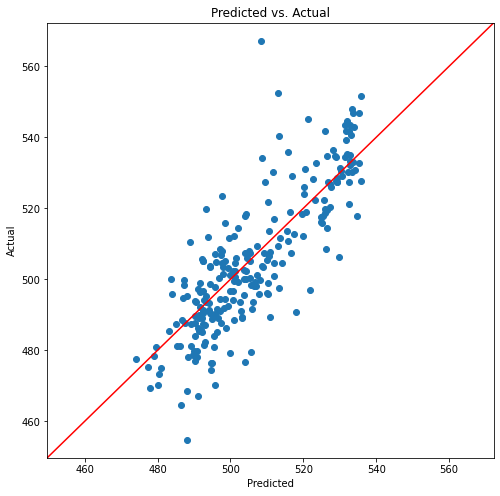

In [16]:
axis_min = min(y_test.min(), min(predicted)) - 5 # pad by 5
axis_max = max(y_test.max(), max(predicted)) + 5 # pad by 5
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(predicted, y_test)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Predicted vs. Actual')
ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
ax.set_xlim([axis_min, axis_max])
ax.set_ylim([axis_min, axis_max])
plt.show()
fig.savefig(performance_path + '/predictedVsActual_scatter.png')

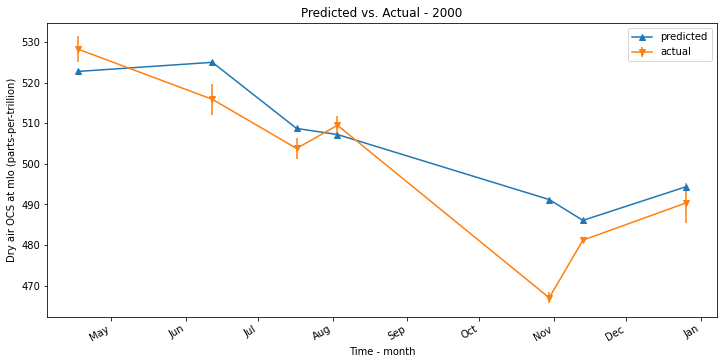

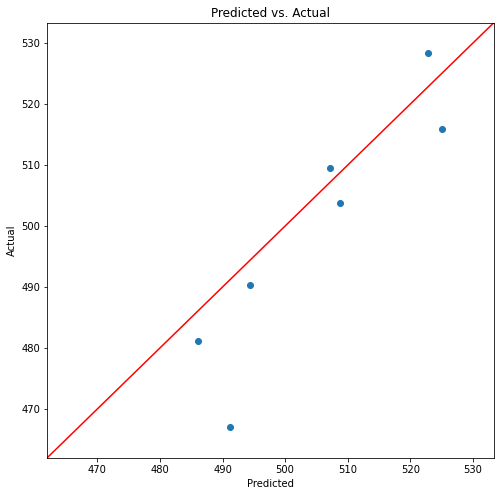

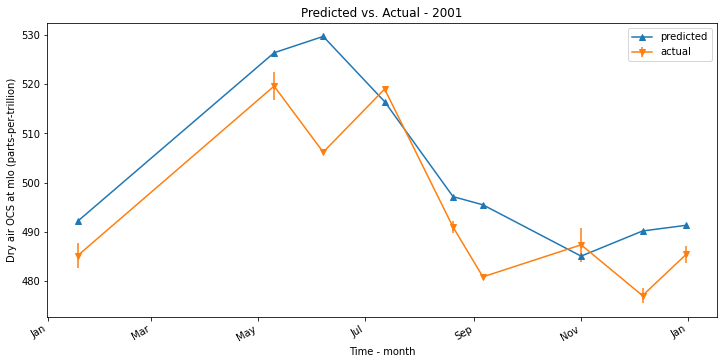

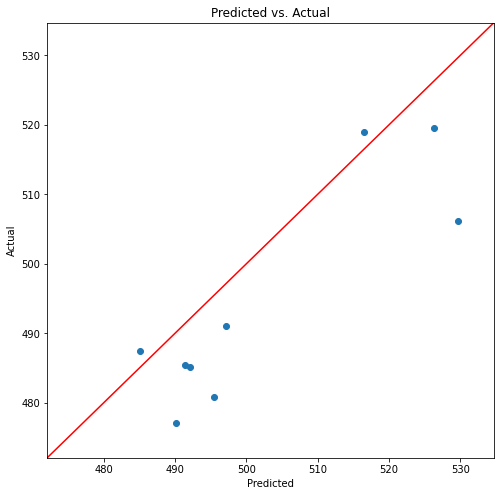

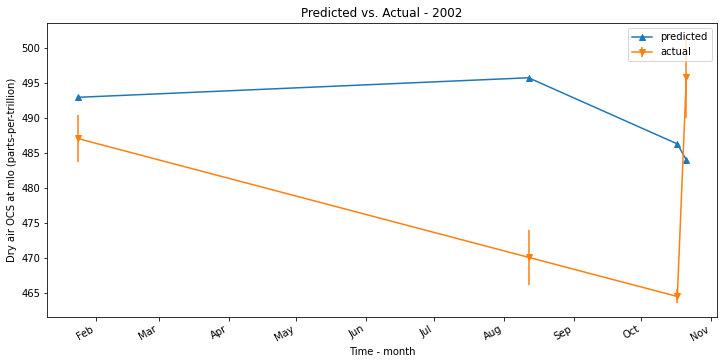

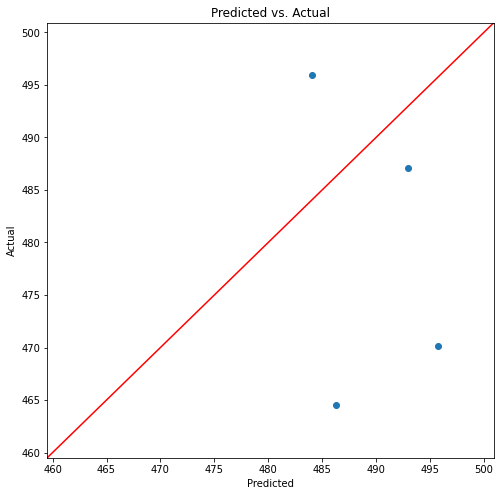

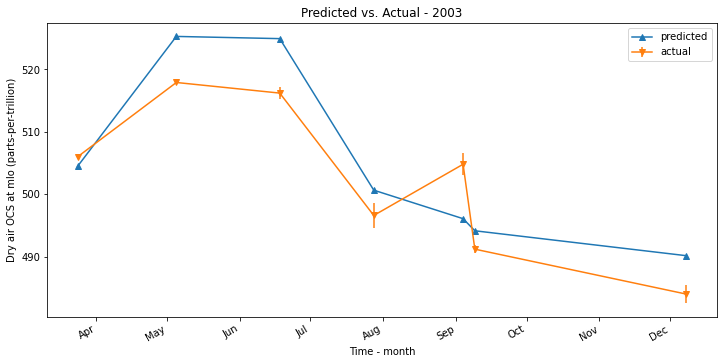

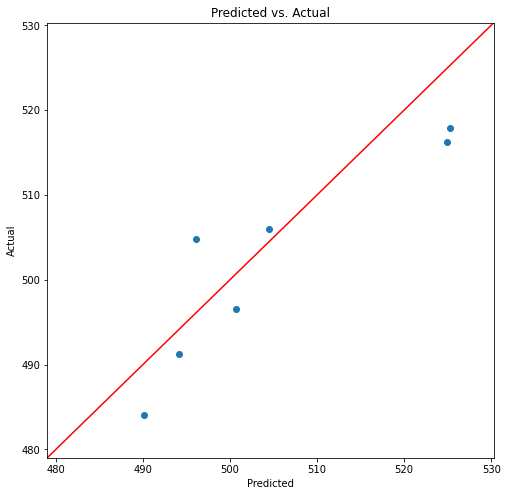

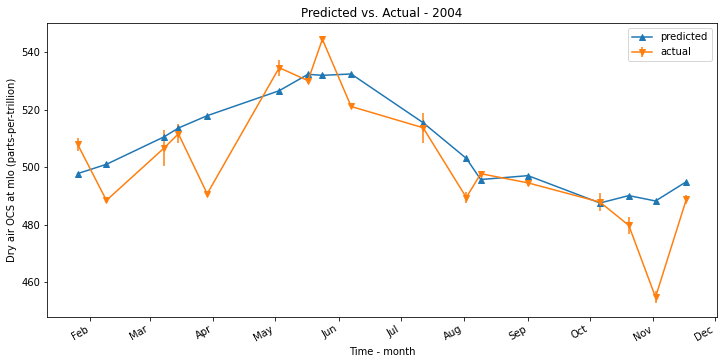

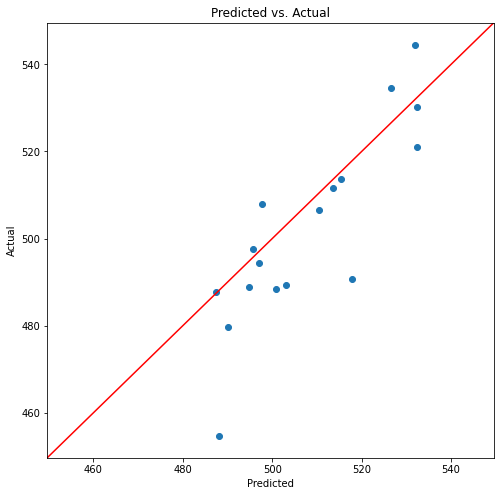

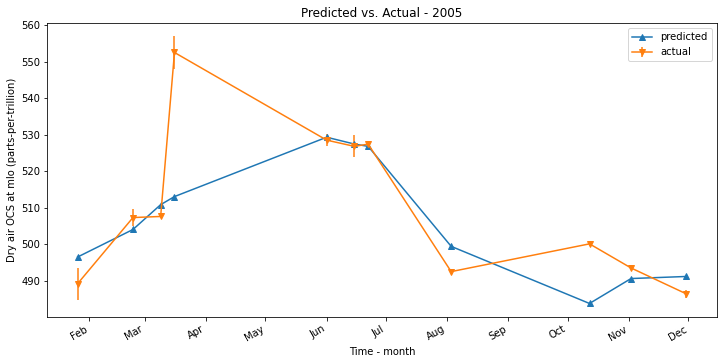

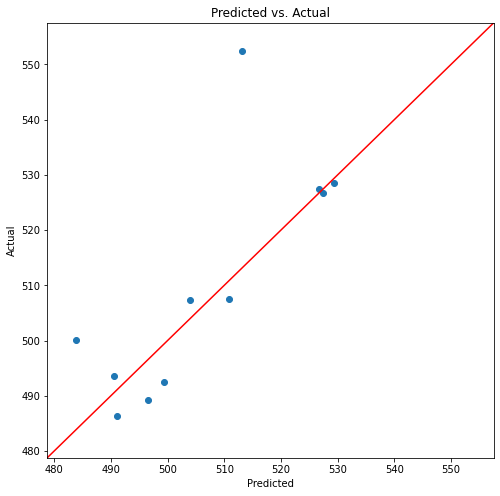

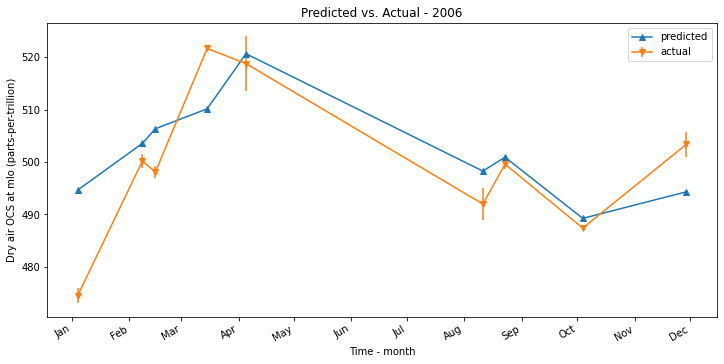

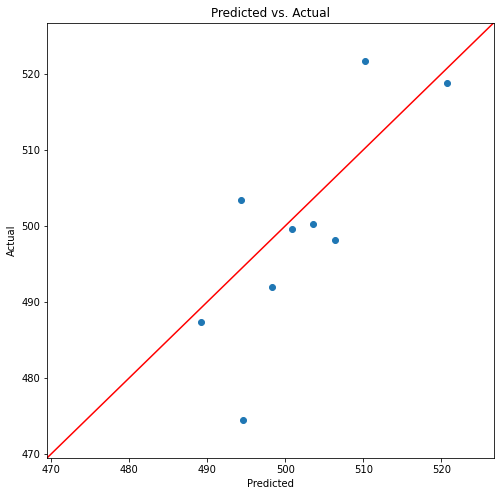

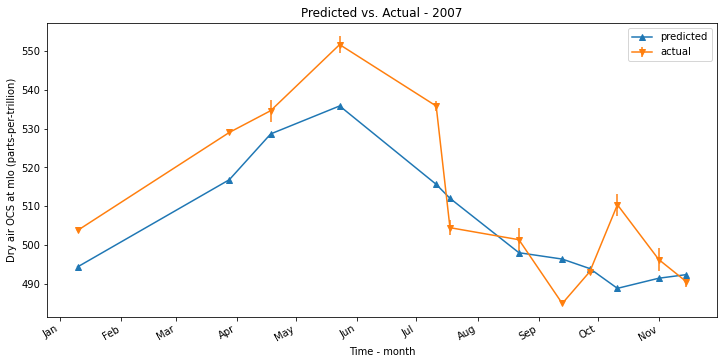

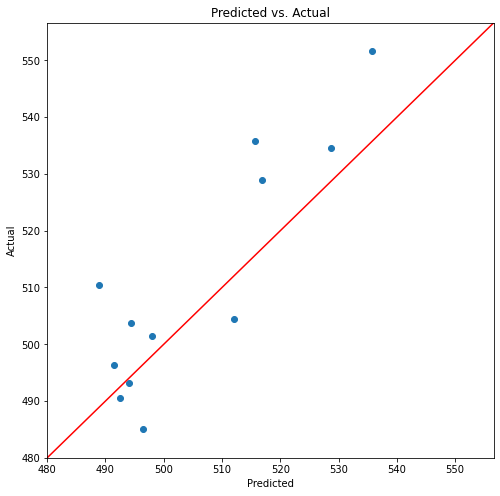

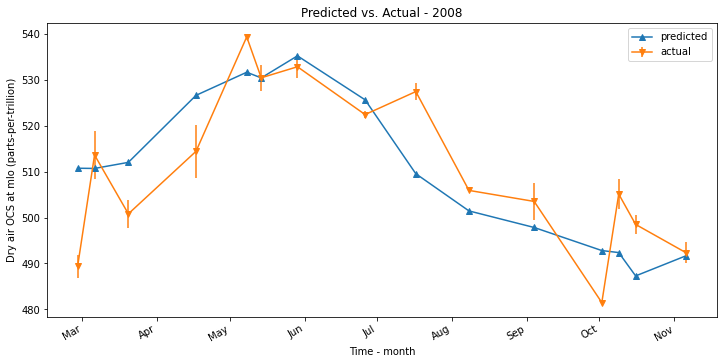

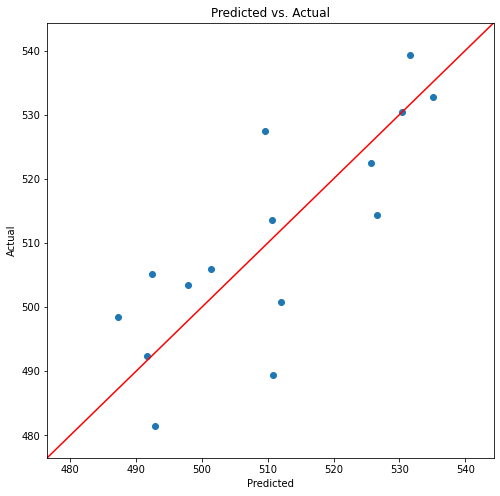

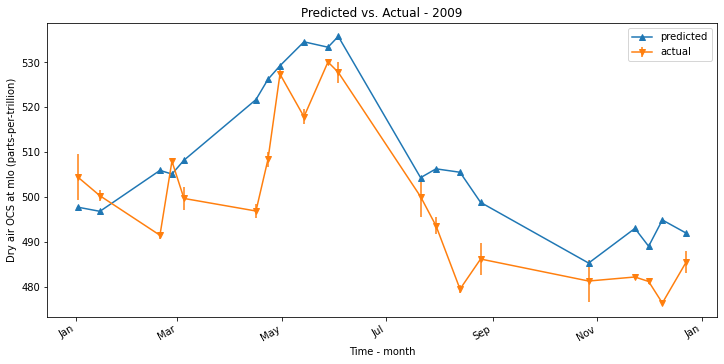

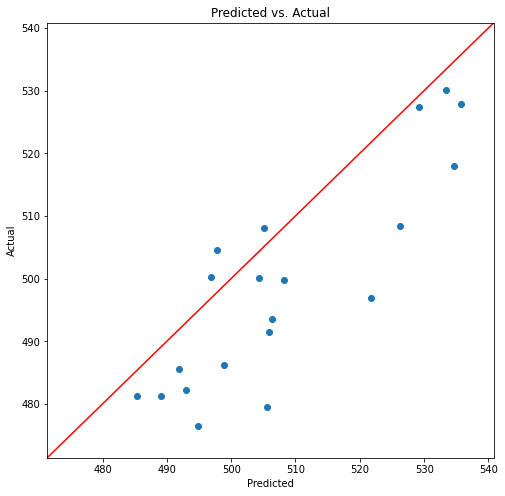

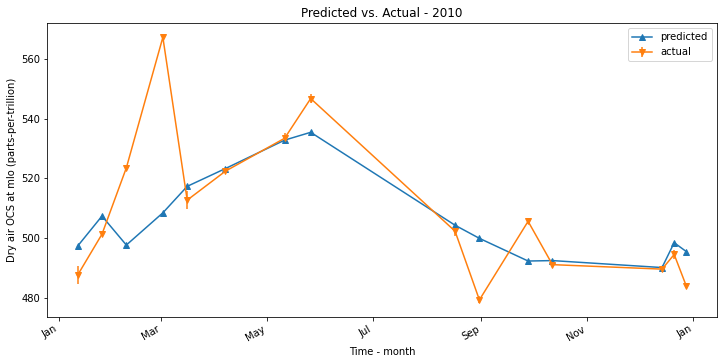

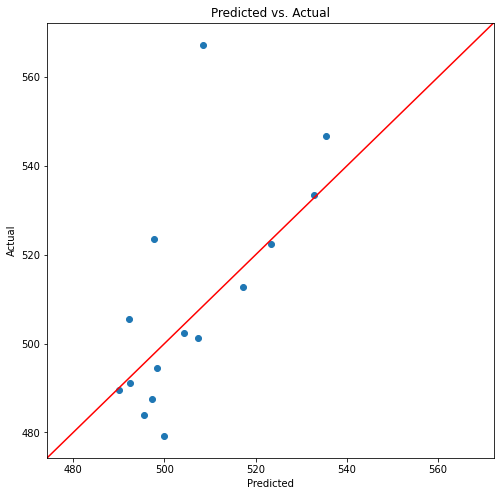

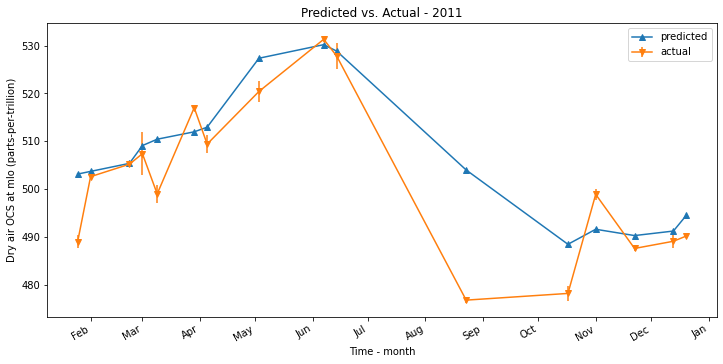

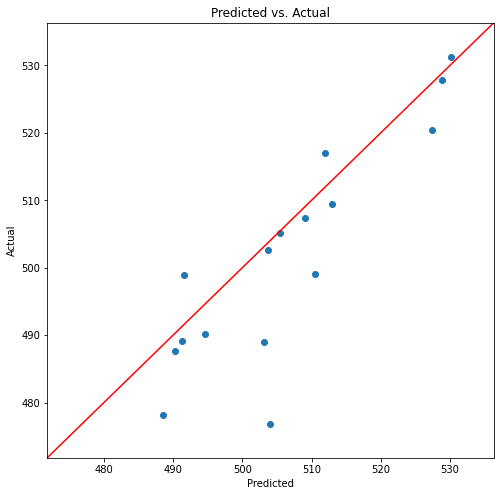

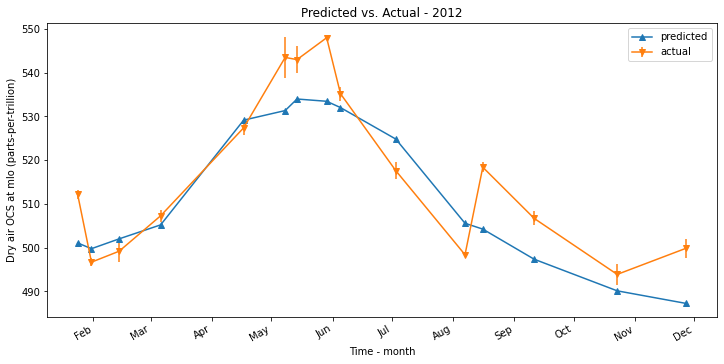

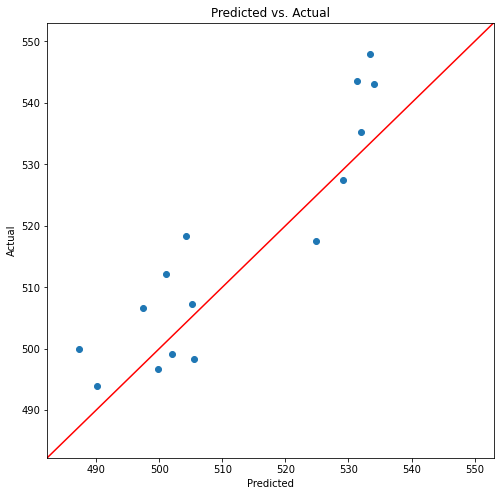

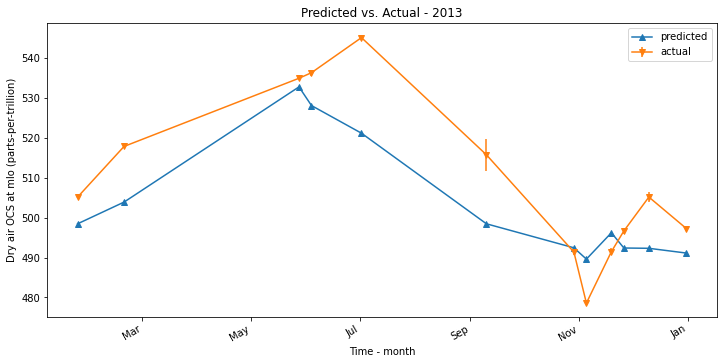

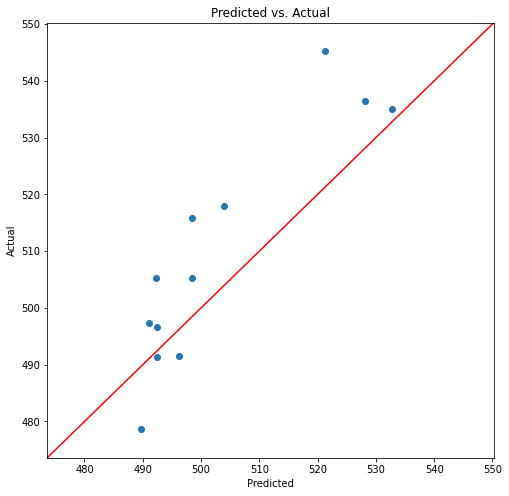

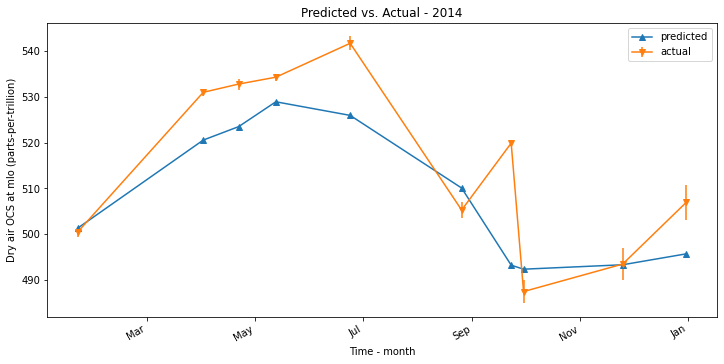

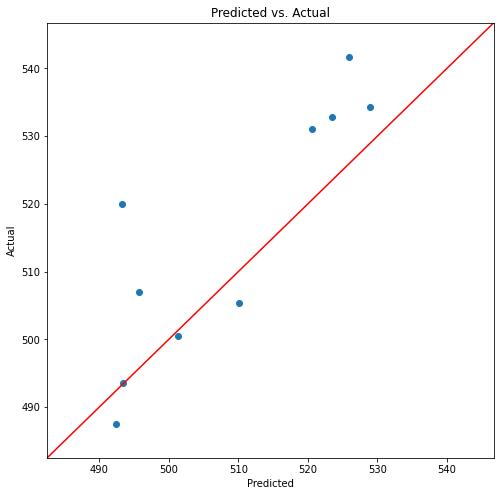

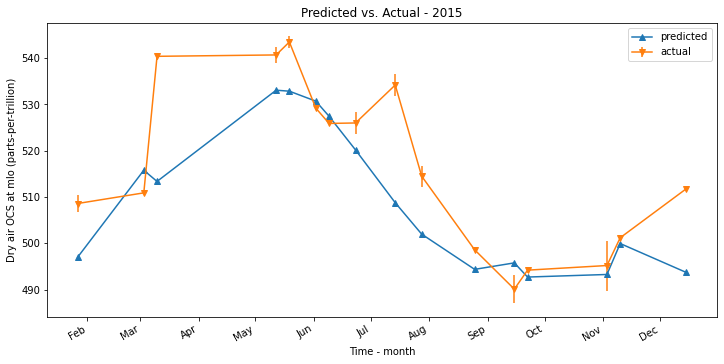

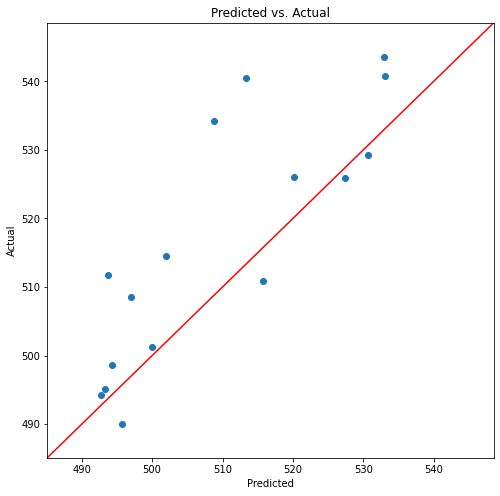

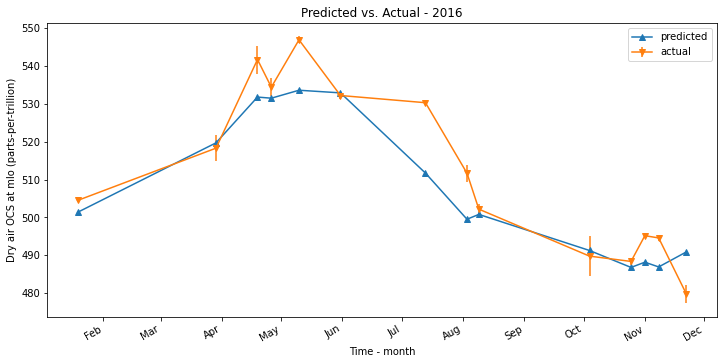

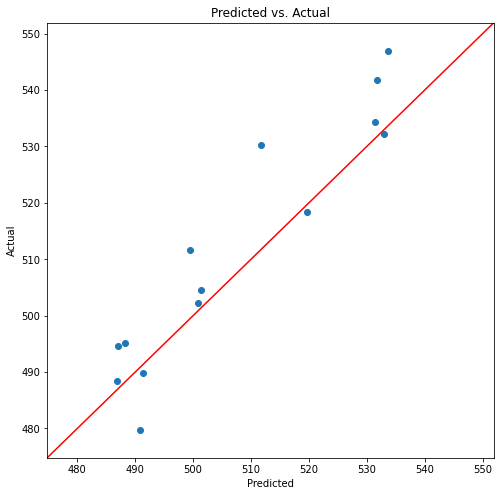

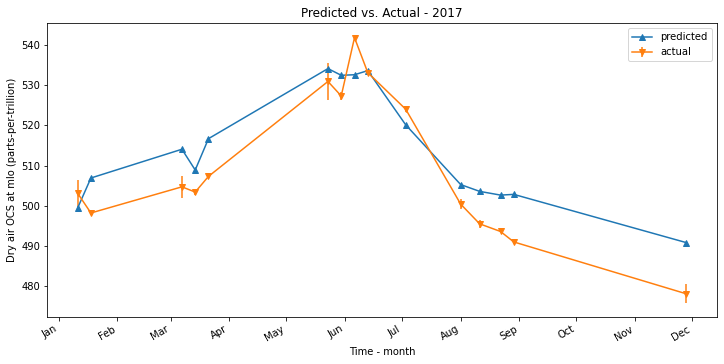

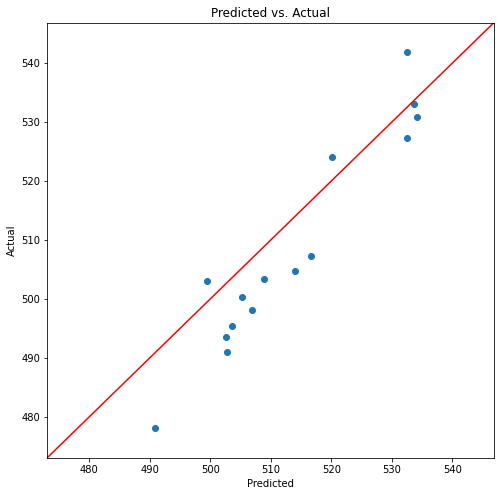

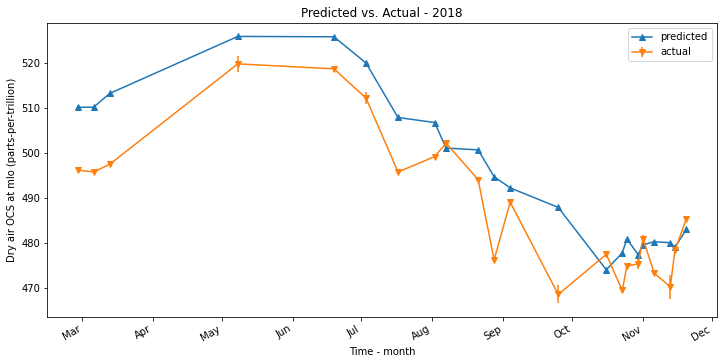

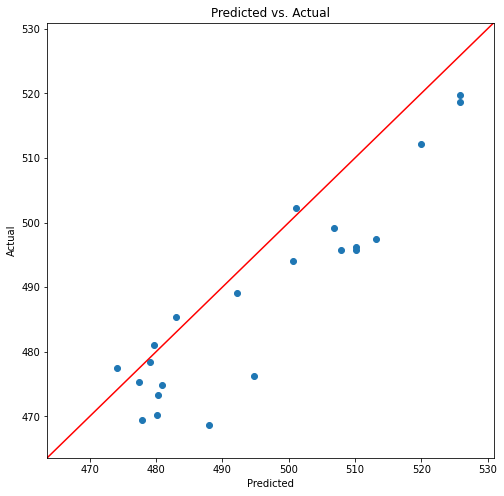

In [17]:
import math
rmse_dict = {'year' : [], 'rmse': []}
for year in test_by_year:
    predicted = ebm.predict(year[2])
    fig,ax = plt.subplots(figsize=(12,6))
    ax.plot(year[1], predicted, '-^', label='predicted')
    ax.errorbar(year[1], year[3], fmt='-v', label='actual', yerr=year[4])
    #ax.plot(year[1], year[3], '-v',label='actual')
    ax.set_title('Predicted vs. Actual - ' + str(year[0]))
    ax.set_xlabel('Time - month')
    ax.set_ylabel('Dry air OCS at ' + cos_site + ' (parts-per-trillion)')
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend()
    plt.show()
    fig_name = str(year[0]) + '-pVSa.png'
    fig.savefig(yearly_path + '/' + fig_name)
    
    axis_min = min(year[3].min(), min(predicted)) - 5 # pad by 5
    axis_max = max(year[3].max(), max(predicted)) + 5 # pad by 5
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(predicted, year[3])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Predicted vs. Actual')
    ax.plot([0,1],[0,1], color='red', transform=ax.transAxes)
    ax.set_xlim([axis_min, axis_max])
    ax.set_ylim([axis_min, axis_max])
    plt.show()
    fig_name = str(year[0]) + '-pVSa_scatter.png'
    fig.savefig(yearly_path + '/' + fig_name)
    
    
    mse = np.square(np.subtract(predicted, year[3])).mean()
    rmse = math.sqrt(mse)
    rmse_dict['year'].append(str(year[0]))
    rmse_dict['rmse'].append(rmse)


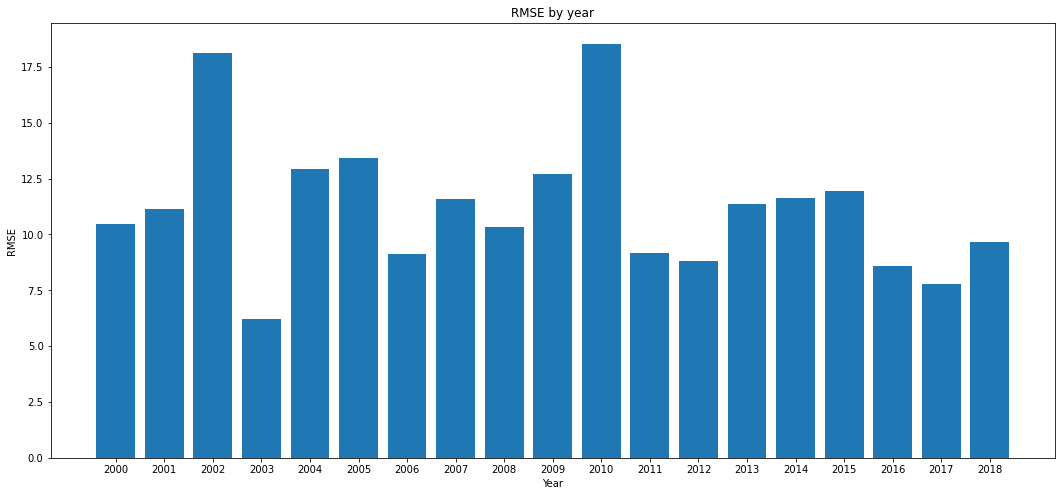

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
ax.bar(rmse_dict['year'], rmse_dict['rmse'])
ax.set_xlabel('Year')
ax.set_ylabel('RMSE')
ax.set_title('RMSE by year')
plt.show()
fig.savefig(performance_path + '/RMSE_Yearly.png')

In [19]:
# print(rmse_dict['year'])
# print(rmse_dict['rmse'])
rmse_sum = sum(rmse_dict['rmse'])
rmse_mean = rmse_sum / len(rmse_dict['rmse'])

sum_squared_diff = 0

for val in rmse_dict['rmse']:
    squared_diff = (val - rmse_mean) ** 2
    sum_squared_diff += squared_diff
variance = sum_squared_diff / len(rmse_dict['rmse'])
print('RMSE Variance = ' +str(variance))
std_deviation = math.sqrt(variance)
print('RMSE Standard Deviation = ' + str(std_deviation))
#print (sum(rmse_dict['rmse']))
#print(len(rmse_dict['rmse']))


RMSE Variance = 9.15450178715662
RMSE Standard Deviation = 3.025640723409939


In [20]:
# save the changes to the current drive (i.e. results and shape functions)
drive.flush_and_unmount()